## CNN图像分类

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
print("PyTorch Version ", torch.__version__)

PyTorch Version  1.7.0


首先我们定义一个基于ConvNet的简单神经网络

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) 
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x)) # 1*28*28 -->  20*24*24
        x = F.max_pool2d(x, 2, 2) # 12*12
        x = F.relu(self.conv2(x)) # 8*8
        x = F.max_pool2d(x, 2, 2) # 4*4   (50*4*4)
        x = x.view(-1, 4*4*50) # reshape (5*2*10) --> view(5,20) --> (5,20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [26]:
mnist_data = datasets.MNIST("./mnist_data", train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))
mnist_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [27]:
mnist_data[0][0].shape

torch.Size([1, 28, 28])

In [28]:
data = [d[0].data.cpu().numpy() for d in mnist_data]

In [29]:
np.mean(data)

0.13066062

In [30]:
np.std(data)

0.30810776

In [38]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # 训练的时候需要所有类别的值计算loss
        pred = model(data) #batch_size * 10
        loss = F.nll_loss(pred, target) # crossentropyloss
        
        #SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if idx % 100 == 0:
            print("Train Epoch: {}, iteration: {}, Loss: {}".format(
                epoch, idx, loss.item()))
        

In [44]:
def test(model, device, test_loader):
    model.eval()
    total_loss = 0.
    correct = 0.
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            
            output = model(data) #batch_size * 10
            total_loss +=  F.nll_loss(output, target, reduction="sum").item() # crossentropyloss
            pred = model(data).argmax(dim=1) #batch_size * 1
            correct += pred.eq(target.view_as(target)).sum().item()
            
    total_loss /= len(test_loader.dataset)
    acc = correct/len(test_loader.dataset) * 100.
    print("Test loss: {}, Accuracy: {}".format(total_loss, acc))

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST("./mnist_data", train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,),(0.3081,))
                               ])),
    batch_size = batch_size, shuffle=True, 
    num_workers=1, pin_memory=True
)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST("./mnist_data", train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,),(0.3081,))
                               ])),
    batch_size = batch_size, shuffle=True, 
    num_workers=1, pin_memory=True
)

lr = 0.01
momentum = 0.5
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

num_epochs = 2
for epoch in range(num_epochs):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)
    

    
torch.save(model.state_dict(), "mnist_cnn.pt")





Train Epoch: 0, iteration: 0, Loss: 2.299640417098999
Train Epoch: 0, iteration: 100, Loss: 0.5468288660049438
Train Epoch: 0, iteration: 200, Loss: 0.32312047481536865
Train Epoch: 0, iteration: 300, Loss: 0.28149548172950745
Train Epoch: 0, iteration: 400, Loss: 0.384483277797699
Train Epoch: 0, iteration: 500, Loss: 0.16364379227161407
Train Epoch: 0, iteration: 600, Loss: 0.18948760628700256
Train Epoch: 0, iteration: 700, Loss: 0.09287521988153458
Train Epoch: 0, iteration: 800, Loss: 0.25484222173690796
Train Epoch: 0, iteration: 900, Loss: 0.022750377655029297
Train Epoch: 0, iteration: 1000, Loss: 0.054387688636779785
Train Epoch: 0, iteration: 1100, Loss: 0.18789170682430267
Train Epoch: 0, iteration: 1200, Loss: 0.0982891246676445
Train Epoch: 0, iteration: 1300, Loss: 0.0823802649974823
Train Epoch: 0, iteration: 1400, Loss: 0.06120816990733147
Train Epoch: 0, iteration: 1500, Loss: 0.16073434054851532
Train Epoch: 0, iteration: 1600, Loss: 0.03568820282816887
Train Epoch: 0

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST("./fashion_mnist_data", train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,),(0.3081,))
                               ])),
    batch_size = batch_size, shuffle=True, 
    num_workers=1, pin_memory=True
)

test_dataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST("./fashion_mnist_data", train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,),(0.3081,))
                               ])),
    batch_size = batch_size, shuffle=True, 
    num_workers=1, pin_memory=True
)

lr = 0.01
momentum = 0.5
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

num_epochs = 2
for epoch in range(num_epochs):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)
    

    
torch.save(model.state_dict(), "fashion_mnist_cnn.pt")





Extracting ./fashion_mnist_data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./fashion_mnist_data\FashionMNIST\raw



Extracting ./fashion_mnist_data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./fashion_mnist_data\FashionMNIST\raw


Extracting ./fashion_mnist_data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./fashion_mnist_data\FashionMNIST\raw



Extracting ./fashion_mnist_data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./fashion_mnist_data\FashionMNIST\raw
Processing...
Done!
Train Epoch: 0, iteration: 0, Loss: 2.314828872680664
Train Epoch: 0, iteration: 100, Loss: 1.0971572399139404
Train Epoch: 0, iteration: 200, Loss: 1.0858162641525269
Train Epoch: 0, iteration: 300, Loss: 0.7038668990135193
Train Epoch: 0, iteration: 400, Loss: 0.8521449565887451
Train Epoch: 0, iteration: 500, Loss: 0.5160807967185974
Train Epoch: 0, iteration: 600, Loss: 0.7510595917701721
Train Epoch: 0, iteration: 700, Loss: 0.6058803200721741
Train Epoch: 0, iteration: 800, Loss: 0.43528836965560913
Train Epoch: 0, iteration: 900, Loss: 0.6089404821395874
Train Epoch: 0, iteration: 1000, Loss: 0.5352737903594971
Train Epoch: 0, iteration: 1100, Loss: 0.47244349122047424
Train Epoch: 0, iteration: 1200, Loss: 0.6922760009765625
Train Epoch: 0, iteration: 1300, Loss: 0.6768542528152466
Train Epoch: 0, iteration: 1400, Loss: 0.3873283863067627
Train

### 常见的卷积神经网络模型

#### LeNet

![](images3/1.png)

#### AlexNet

![](images3/2.png)

#### VGGNet

![](images3/3.png)

#### ResNet

![](images3/4.png)

![](images3/5.png)

#### DenseNet

![](images3/6.png)



### CNN模型的迁移学习
- 很多时候我们需要训练一个新的图像分类任务，我们不会完全从一个随机的模型开始训练，而是利用预训练的模型来加速训练的过程。我们经常使用在ImageNet上的预训练模型。
- 这是一种transfer learning的方法，我们常用以下两种方法做迁移学习：
    - fine tuning:从一个预训练模型开始，我们改变一些模型的架构，然后继续训练整个模型的参数。
    - feature extraction：我们不再改变与训练模型的参数，而是只更新我们改变过的部分模型参数。我们之所以叫它feature extraction是因为我们把预训练的CNN模型当做一个特征提取模型，利用提取出来的特征来完成我们的训练人物

以下是构建和训练迁移学习模型的基本步骤：

- 初始化预训练模型
- 把最后一层的输出曾改编成我们想要分的类别总数
- 定义一个optimizer来更新参数
- 模型训练

In [5]:
import numpy as np
import torchvision
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import time
import os
import copy
print("Torchvision version: ",torchvision.__version__)

Torchvision version:  0.8.1


### 数据

采用*hymenoptera_data*数据集

这个数据集包括两类图片，**bees** 和 **ants**，这些数据都被处理成了可以使用`ImageFolder<https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`来读取的格式。我们只需把``data_dir``设置成数据的根目录，然后把``model_name``设置成我们想要使用的预训练模型：

[resnet, alenet, vgg, squeezenet, densenet, inception]

其他的参数有：
- ``num_classes``表示数据集分类的类别数
- ``batch_size``
- ``num_epochs``
- ``featur_extract``表示我们训练的时候使用fine tuning还是feature extraction方法。如果feature_extract = False，整个模型会被同时更新。如果feature_extract = True，只有模型的最后一层被更新。



In [9]:
data_dir = "./hymenoptera_data"
model_name = "resnet"
num_classes = 2
batch_size = 32
num_epochs = 15
feature_extract = True
input_size = 224

### 读入数据

现在我们知道了模型输入的size，我们就可以把数据预处理成相应的格式。

In [12]:
all_imgs = datasets.ImageFolder(os.path.join(data_dir, "train"), transforms.Compose([
        transforms.RandomResizedCrop(input_size), # 截取一个区域
        transforms.RandomHorizontalFlip(), # 左右进行翻转，数据更noisy一点
        transforms.ToTensor(),
    ]))
loader = torch.utils.data.DataLoader(all_imgs, batch_size=batch_size, shuffle=True, num_workers=4)

### ImageFolder

ImageFolder:自动分类,是一个通用的数据加载器，它要求我们以下面这种格式来组织数据集的训练、验证或者测试图片。

root/dog/xxx.png  root/cat/123.png

返回的dataset都有以下三种属性：

- self.classes：用一个 list 保存类别名称
- self.class_to_idx：类别对应的索引，与不做任何转换返回的 target 对应
- self.imgs：保存(img-path, class) tuple的 list

In [30]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size), # 截取一个区域
        transforms.RandomHorizontalFlip(), # 左右进行翻转，数据更noisy一点
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # 平均值和标准差
    ]),
    "val":transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size), # 永远在中间截取一段图片
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # 平均值和标准差
    ])

}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val"]}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x],
        batch_size=batch_size, shuffle=True, num_workers=4)for x in ["train", "val"]}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
img = next(iter(loader))[0]

In [16]:
img.shape # batch_size ,channel, 224,224

torch.Size([32, 3, 224, 224])

In [31]:
img = next(iter(dataloaders_dict["val"]))[0]

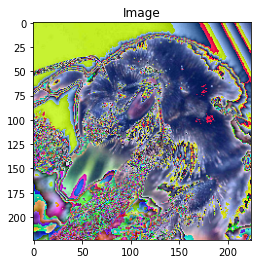

In [32]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image) # tensor转化为图片
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(img[0], title='Image')


In [19]:
model_ft = models.resnet18()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=use_pretrained) # true:拿到被预训练过的resnet
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("model not implemented")
        return None, None
    return model_ft, input_size

model_ft, input_size = initialize_model(model_name, 
                    num_classes, feature_extract, use_pretrained=True)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
model_ft.layer1[0].conv1.weight.requires_grad

False

In [25]:
model_ft.fc.weight.requires_grad

True

In [45]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    val_acc_history = []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            
            running_loss = 0.
            running_corrects = 0.
            
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                
                with torch.autograd.set_grad_enabled(phase=="train"):
                    outputs = model(inputs) # bsize * 2
                    loss = loss_fn(outputs, labels)
                    
                preds = outputs.argmax(dim=1) 
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            print("Phase {} loss: {}, acc: {}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase == "val":
                val_acc_history.append(epoch_acc)
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

模型训练

In [46]:
model_ft = model_ft.to(device)

In [47]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, 
                                   model_ft.parameters()), lr = 0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [49]:
_, ohist = train_model(model_ft, dataloaders_dict, loss_fn, optimizer, num_epochs=num_epochs)

Phase train loss: 0.21043107646410583, acc: 0.9385245901639344
Phase val loss: 0.22383471388442844, acc: 0.9215686274509803
Phase train loss: 0.21678563195173858, acc: 0.8975409836065574
Phase val loss: 0.21851373653785855, acc: 0.9215686274509803
Phase train loss: 0.19720532903905774, acc: 0.9426229508196722
Phase val loss: 0.21253421065074946, acc: 0.9281045751633987
Phase train loss: 0.17288352646788613, acc: 0.9385245901639344
Phase val loss: 0.22163643186388451, acc: 0.9150326797385621
Phase train loss: 0.18770966275793607, acc: 0.9385245901639344
Phase val loss: 0.207628869737675, acc: 0.934640522875817
Phase train loss: 0.1969579023415925, acc: 0.9221311475409836
Phase val loss: 0.20303052615106496, acc: 0.934640522875817
Phase train loss: 0.210812546679231, acc: 0.9262295081967213
Phase val loss: 0.20926987754753212, acc: 0.9215686274509803
Phase train loss: 0.17121238420244123, acc: 0.9344262295081968
Phase val loss: 0.20388930003627453, acc: 0.9411764705882353
Phase train los

In [50]:
model_scratch, _ = initialize_model(model_name, 
                    num_classes, feature_extract=False, use_pretrained=False)
model_scratch = model_scratch.to(device)

optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, 
                                   model_scratch.parameters()), lr = 0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

_,scratch_hist = train_model(model_scratch, dataloaders_dict, loss_fn, optimizer, num_epochs=num_epochs) 

Phase train loss: 0.799374379095484, acc: 0.5286885245901639
Phase val loss: 0.6882974743063933, acc: 0.5424836601307189
Phase train loss: 0.7094993855132431, acc: 0.5532786885245902
Phase val loss: 0.71246438789991, acc: 0.46405228758169936
Phase train loss: 0.6550482980540542, acc: 0.6065573770491803
Phase val loss: 0.6139008691108304, acc: 0.673202614379085
Phase train loss: 0.641692448834904, acc: 0.639344262295082
Phase val loss: 0.5993834620986889, acc: 0.6993464052287581
Phase train loss: 0.5986831676764567, acc: 0.6639344262295082
Phase val loss: 0.6073182160947838, acc: 0.673202614379085
Phase train loss: 0.6061481139698967, acc: 0.639344262295082
Phase val loss: 0.6328085201238495, acc: 0.6274509803921569
Phase train loss: 0.5955106664876468, acc: 0.6434426229508197
Phase val loss: 0.5757021413129919, acc: 0.7189542483660131
Phase train loss: 0.5631575320587784, acc: 0.6926229508196722
Phase val loss: 0.5751874302726945, acc: 0.7320261437908496
Phase train loss: 0.55575708287

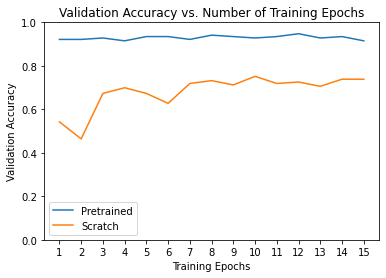

In [51]:

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),scratch_hist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()